# Fig 5 MRE Velocity

This notebook makes velocity plots.

## Initialization

In [1]:
# First import the necessary packages
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib
import os

# Set the verbosity of scVelo
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=200, frameon=False)
cr.settings.verbosity = 2

# Fonts for illustrator
import matplotlib.font_manager as fm

# Optional: confirm font file is in the right place
font_path = os.path.expanduser("/home/dalbao/.fonts/arial.ttf")
fm.fontManager.addfont(font_path)
arial_font = fm.FontProperties(fname=font_path)

# Editable text in PDF outputs
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = arial_font.get_name()

/opt/conda/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/opt

['#1f77b4' '#ff7f0e' '#279e68' '#d62728' '#aa40fc' '#8c564b' '#e377c2'
 '#b5bd61' '#17becf' '#aec7e8' '#ffbb78' '#98df8a' '#ff9896' '#c5b0d5'
 '#c49c94' '#f7b6d2']


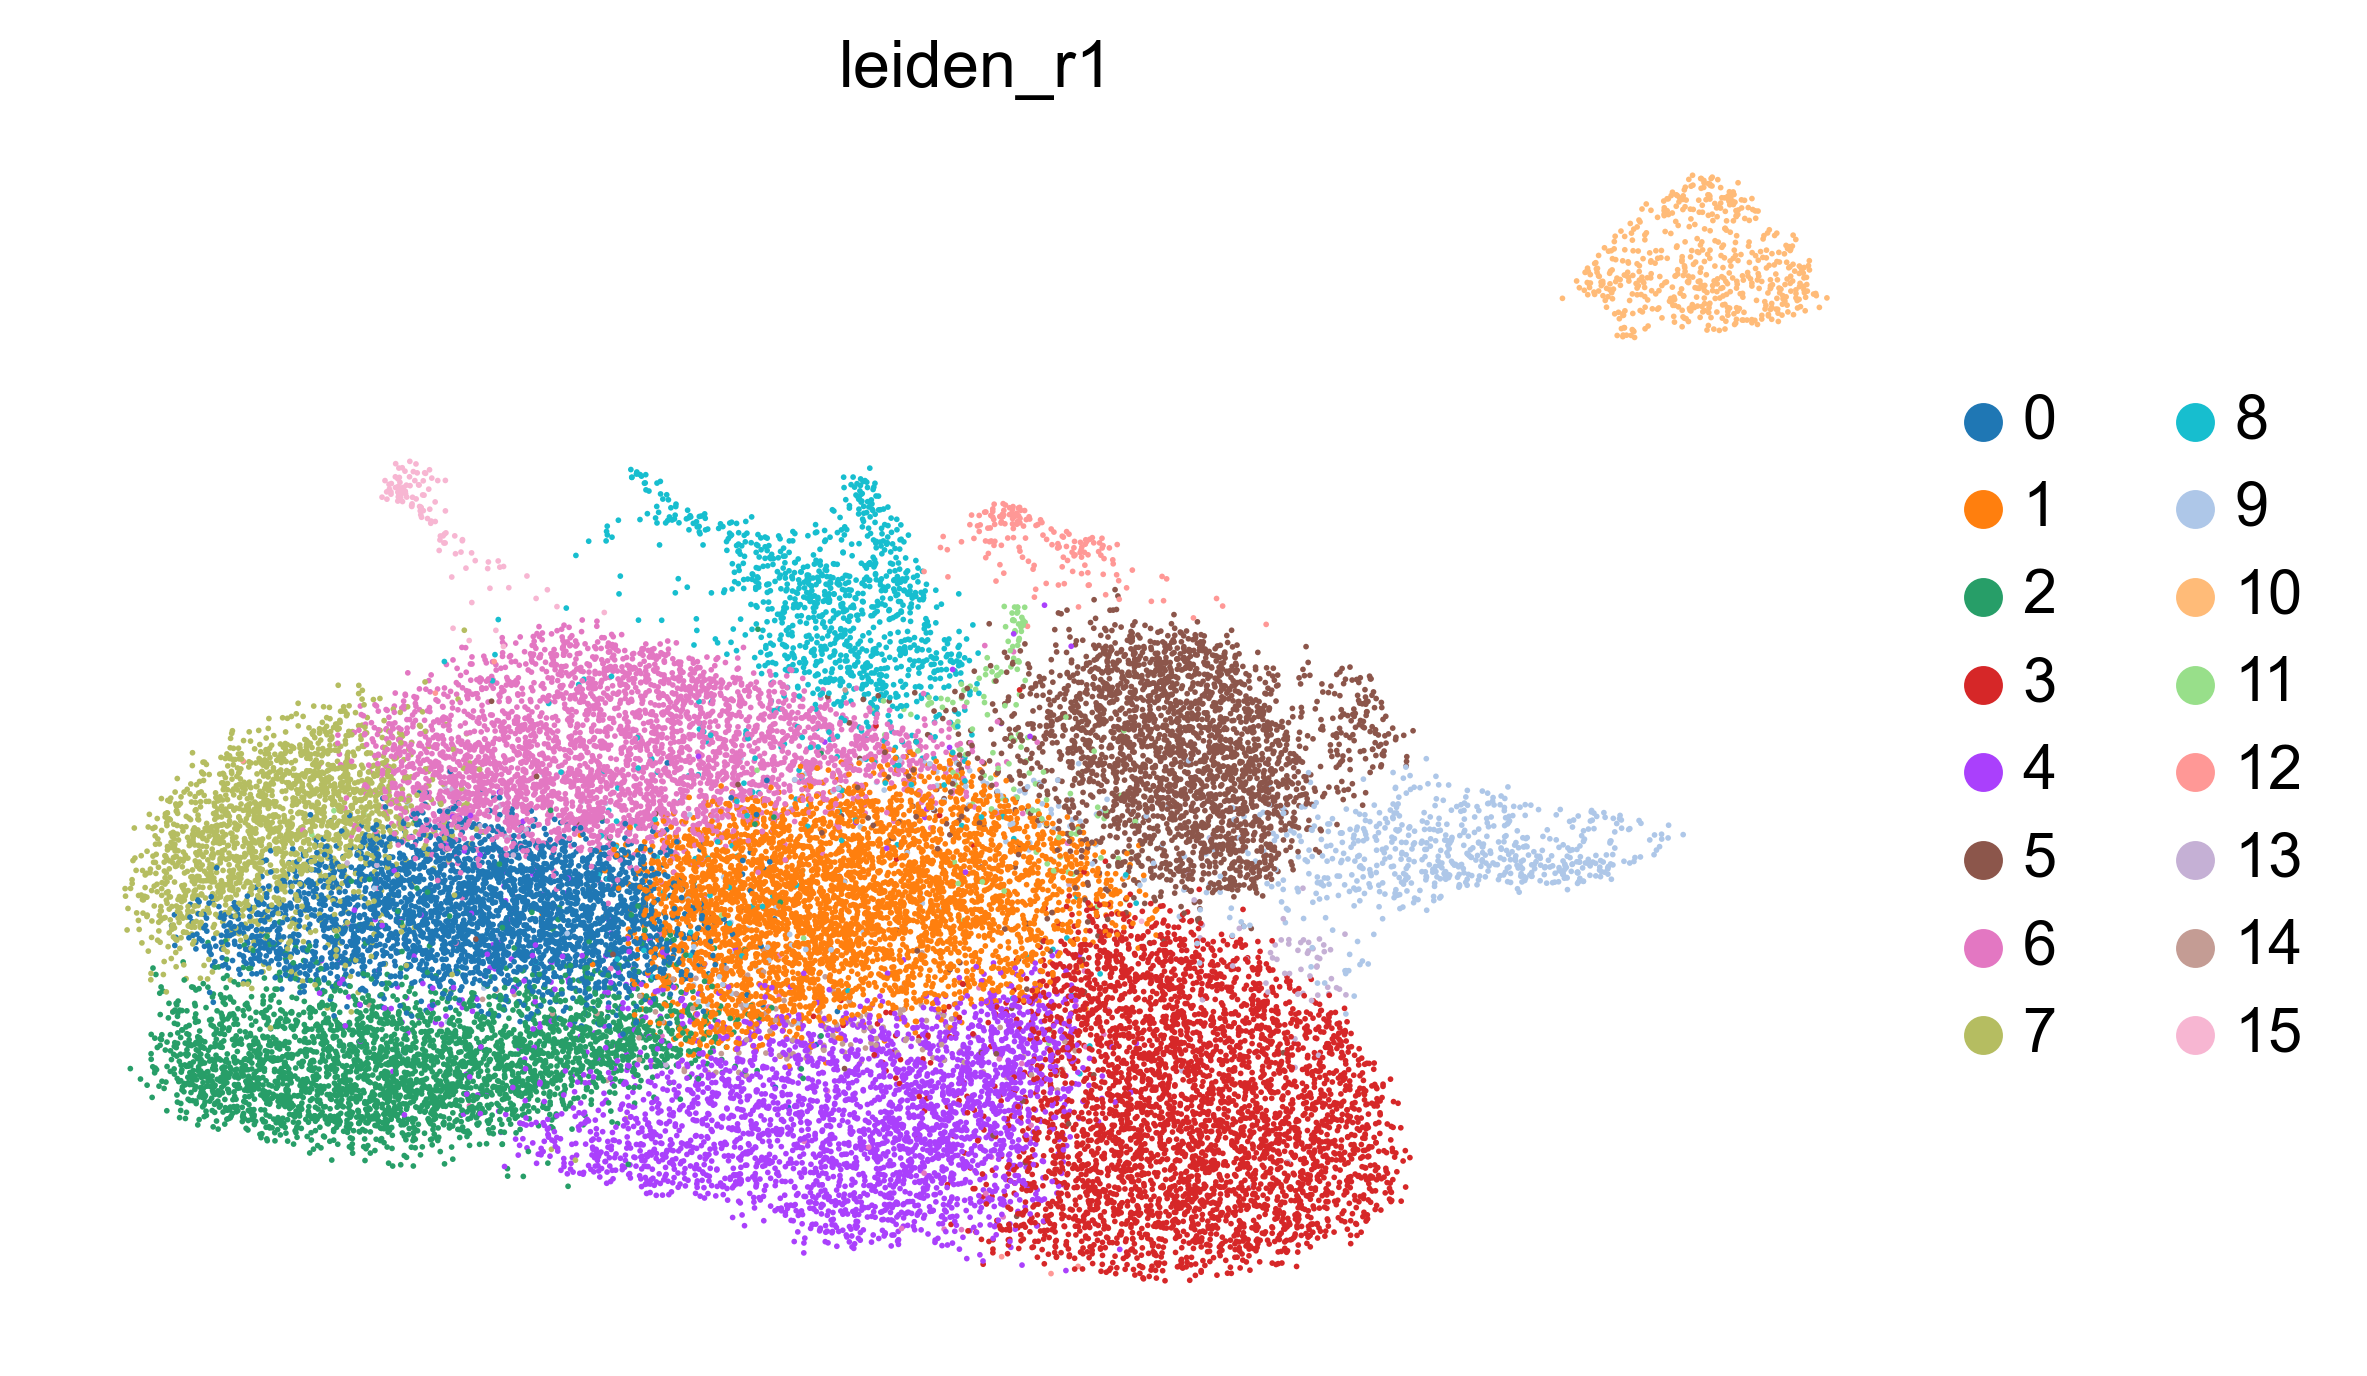

In [2]:
# Set location
os.chdir("/home/dalbao/2023-012-Runx3mutD8scRNA/AlbaoRunx3Manuscript/figures/05")

# Read in the data
adata = ad.read_h5ad("../../h5ad/07_25-12-09-10-50_velocity_MRE.h5ad")

# Check object
adata

# Plot umap with leiden_r1 clustering
sc.pl.umap(adata, color=["leiden_r1"], frameon=False, show=False)

# Colors
print(adata.uns['leiden_r1_colors'])

## Extract Velocities

In [3]:
# Create a new object adata_sub.obs which only contains the leiden_r1 groups
# '0', '1', '2', '3', '4', '5', '6'
adata_sub = adata[adata.obs['leiden_r1'].isin(['0', '1', '2', '3', '4', '5', '6', '7'])].copy()

# add the prefix MRE to the leiden_r1 groups
adata_sub.obs['leiden_r1'] = 'MRE' + adata_sub.obs['leiden_r1'].astype(str)

# Reconvert into cateogories
adata_sub.obs['leiden_r1'] = adata_sub.obs['leiden_r1'].astype('category')

In [4]:
from scipy import sparse

# -----------------------------
# 1. Subset to HVGs + markers
# -----------------------------

hvg_mask = adata_sub.var["highly_variable"].values.astype(bool)

marker_genes = [
    "Klrg1","Il7r","Cx3cr1","Cd27","Bach2","Foxo1","Id3","Lef1",
    "Tcf7","Zeb1","Eomes","Id2","Prdm1","Tbx21","Zeb2","Tox",
    "Prf1","Gzmb","Ifng","Runx1","Runx2","Runx3","Itgae"
]

marker_mask = adata_sub.var_names.isin(marker_genes)

# Warn about missing markers
missing_markers = sorted(set(marker_genes) - set(adata_sub.var_names))
if missing_markers:
    print("Warning, missing markers:", missing_markers)

# Combined mask
gene_mask = hvg_mask | marker_mask

# Subset AnnData to these genes
adata_vel = adata_sub[:, gene_mask].copy()

# Gene names
gene_names = adata_sub.var_names[gene_mask]

# -----------------------------
# 2. Extract VELOCITY matrix
# -----------------------------
# Change this to "spliced" or "unspliced" if needed:
layer_name = "velocity"

vel_mat = adata_vel.layers[layer_name]

# Convert sparse → dense if necessary
if sparse.issparse(vel_mat):
    vel_mat = vel_mat.toarray()

# -----------------------------
# 3. Build DataFrame
# -----------------------------

df_vel = pd.DataFrame(
    vel_mat,
    index=adata_vel.obs_names,
    columns=gene_names
)

# -----------------------------
# 4. Add group information
# -----------------------------

df_vel["group"] = adata_vel.obs["leiden_r1"].values

# -----------------------------
# 5. Compute group-wise mean velocity
# -----------------------------

df_mean = df_vel.groupby("group", observed=True).mean()

# -----------------------------
# 6. Transpose for readability
# -----------------------------

df_mean = df_mean.transpose()

def tanh_transform(df, scale=1):
    return np.tanh(df / scale)

df_tanh = tanh_transform(df_mean, scale=1)

# -----------------------------
# 7. Save
# -----------------------------

df_mean.to_csv("../../csv/figure05_MRE_meanVelocity.csv")
df_tanh.to_csv("../../csv/figure05_MRE_tanhVelocity.csv")


## Velocity Streams

In [5]:
print(adata)
print(adata.obs.group.value_counts())
unique_leiden = adata.obs.leiden_r1.unique()

# Remove ['0', '2', '4', '7'] from unqiue_leiden
unique_leiden = unique_leiden[~unique_leiden.isin(['2', '3', '4', '5'])]
print(unique_leiden)

# Make new obs column called leiden_mod
# If leiden_r1 is equal ['0', '2', '4', '7'] then leiden_mod is equal to leiden_r1
# Otherwise, leiden_mod = 'NA'
adata.obs['leiden_mod'] = adata.obs['leiden_r1'].copy()
adata.obs['leiden_mod'] = adata.obs['leiden_mod'].astype(str)
adata.obs['leiden_mod'] = adata.obs['leiden_mod'].replace(unique_leiden, ['NA'] * len(unique_leiden))

AnnData object with n_obs × n_vars = 28407 × 18505
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'gem', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.9', 'leiden_r0.8', 'leiden_r0.7', 'leiden_r0.6', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'leiden_r0.1', 'leiden_r1_as_resolved', 'sample_batch', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'mt', 'ribo', 'n_cells_by_counts-gem1', 'mean_counts-gem1', 'log1p_mean_cou

In [6]:
print(adata.obs['leiden_mod'].value_counts())
adata.uns["leiden_r1_colors"]

# Make leiden_mod a categorical variable with order
# '0', '2', '3', '4', '5', 'NA'
adata.obs['leiden_mod'] = pd.Categorical(adata.obs['leiden_mod'], categories=['2', '3', '4', '5', 'NA'], ordered=True)

# Make an uns category called leiden_mod_colors
adata.uns['leiden_mod_colors'] = ['#2077b4', '#269d68', '#1dbece', '#8c564b', "#d5d5d5"]

leiden_mod
NA    15772
3      3845
2      3187
4      3020
5      2583
Name: count, dtype: int64


saving figure to file ./figures/scvelo_MRE_Fig5F.svg


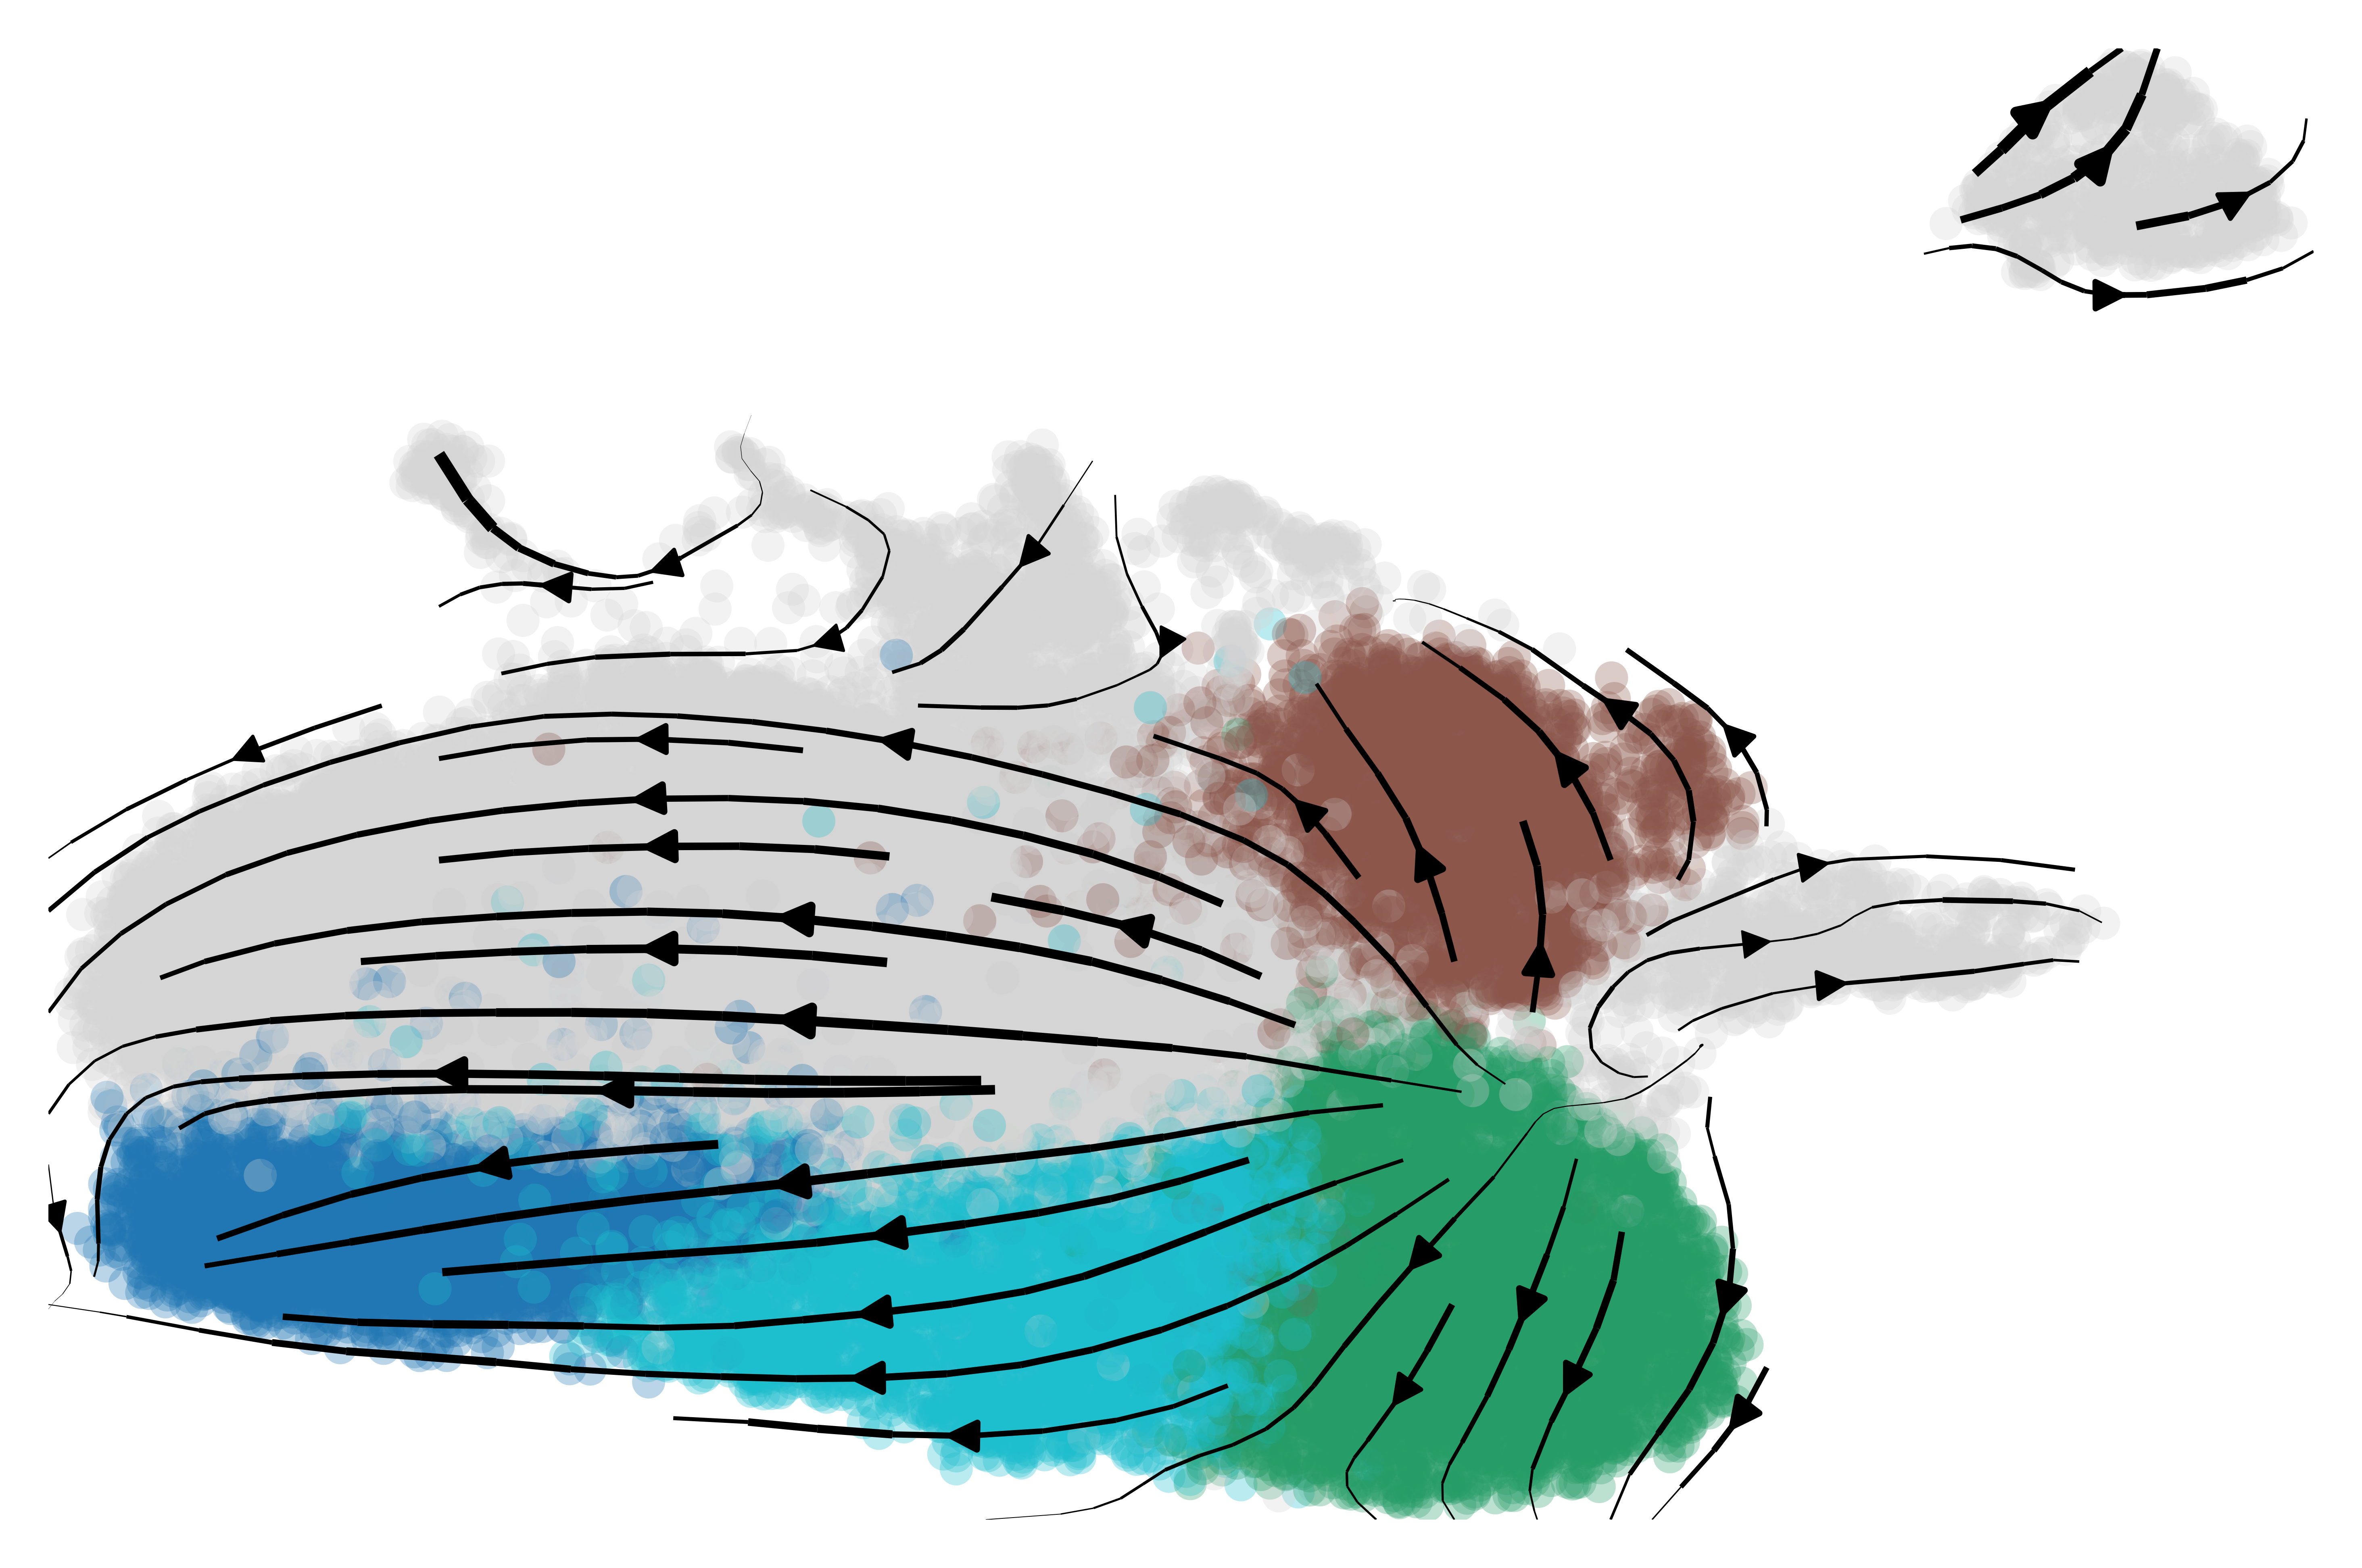

In [7]:
scv.pl.velocity_embedding_stream(   adata,
                                    basis='umap',
                                    color=['leiden_mod'],
                                    title='',
                                    density = 1,
                                    dpi=600,
                                    legend_loc='none',
                                    save= 'MRE_Fig5F.svg')